In [1]:
# Import Library
from pyspark.sql import SparkSession
import pandas as pd
from pandas.plotting import scatter_matrix
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [2]:
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
DATA_PATH = '/Users/ferdinand/Desktop/CEBD1261_assignment/project/hotel_bookings.csv'
raw_df = spark.read.csv(DATA_PATH, header = True, inferSchema = True)
raw_df.printSchema()


df = raw_df.select('is_canceled',
                   'lead_time',
                   'arrival_date_year',
                   'arrival_date_week_number',
                   'arrival_date_day_of_month',
                   'stays_in_weekend_nights',
                   'stays_in_week_nights',
                   'adults',
                   'babies',
                   'is_repeated_guest',
                   'previous_cancellations',
                   'previous_bookings_not_canceled',
                   'booking_changes',
                   'days_in_waiting_list',
                   'required_car_parking_spaces',
                   'total_of_special_requests',
                   'hotel',
                   'children',
                   'meal',
                   'country',
                   'market_segment',
                   'distribution_channel',
                   'reserved_room_type', 
                   'assigned_room_type',
                   'deposit_type',
                   'agent',
                   'company',
                   'customer_type',
                   'adr',
                   'reservation_status')
cols = df.columns
# INPUT VARIABLE: all features except is_cancelled
# OUTPUT VARIABLE: is_cancelled


root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

In [3]:
# DATA OBSERVATION
pd.DataFrame(df.take(5), columns=df.columns).transpose()


,0,1,2,3,4
is_canceled,0,0,0,0,0
lead_time,342,737,7,13,14
arrival_date_year,2015,2015,2015,2015,2015
arrival_date_week_number,27,27,27,27,27
arrival_date_day_of_month,1,1,1,1,1
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,0,0,1,1,2
adults,2,2,1,1,2
babies,0,0,0,0,0
is_repeated_guest,0,0,0,0,0


In [4]:
# SUMMARY STATISTIC OF NUMERICAL FEATURES
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
is_canceled,119390,0.37041628277075134,0.48291822659259825,0,1
lead_time,119390,104.01141636652986,106.86309704798794,0,737
arrival_date_year,119390,2016.156554150264,0.7074759445192997,2015,2017
arrival_date_week_number,119390,27.16517296255968,13.605138355497655,1,53
arrival_date_day_of_month,119390,15.798241058715135,8.780829470578349,1,31
stays_in_weekend_nights,119390,0.9275986263506156,0.9986134945978749,0,19
stays_in_week_nights,119390,2.500301532791691,1.9082856150479137,0,50
adults,119390,1.8564033838679956,0.5792609988327534,0,55
babies,119390,0.007948739425412514,0.0974361913012644,0,10


In [5]:
# CREATE NUMERICAL FEATURES
numeric_features_df = raw_df.select('lead_time',
                                    'arrival_date_year',
                                    'arrival_date_week_number',
                                    'arrival_date_day_of_month',
                                    'stays_in_weekend_nights',
                                    'stays_in_week_nights',
                                    'adults',
                                    'babies',
                                    'is_repeated_guest',
                                    'previous_cancellations',
                                    'previous_bookings_not_canceled',
                                    'booking_changes',
                                    'days_in_waiting_list',
                                    'required_car_parking_spaces',
                                    'total_of_special_requests')
# target_df.printSchema()
# indep_df.printSchema()

In [6]:
# ENCODE CATEGORICAL COLUMNS
categoricalColumns = ['hotel',
                      'children',
                      'meal',
                      'country',
                      'market_segment',
                      'distribution_channel',
                      'reserved_room_type',
                      'assigned_room_type',
                      'deposit_type',
                      'agent',
                      'company',
                      'customer_type',
                      'adr',
                      'reservation_status']

stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]


label_stringIdx = StringIndexer(inputCol = 'is_canceled', outputCol = 'label')
stages += [label_stringIdx]    
    

numericCols = ['lead_time',
               'arrival_date_year',
               'arrival_date_week_number', 
               'arrival_date_day_of_month',
               'stays_in_weekend_nights',
               'stays_in_week_nights',
               'adults',
               'babies',
               'is_repeated_guest',
               'previous_cancellations',
               'previous_bookings_not_canceled',
               'booking_changes',
               'days_in_waiting_list',
               'required_car_parking_spaces',
               'total_of_special_requests']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols = assemblerInputs,outputCol="features")
stages += [assembler]

In [7]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label','features']+ cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- babies: integer (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- booking_changes: integer (nullable = true)
 |-- days_in_waiting_list: integer (nullable = true)
 |-- required_car_parking_spaces: integer (nullable = true)
 |-- total_of_special_requests: integer (nullable = true)
 |-- hotel: string (nullable = true)
 |-- children: string (nullable = true)
 |-- meal: stri

In [8]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()


,0,1,2,3,4
label,0,0,0,0,0
features,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
is_canceled,0,0,0,0,0
lead_time,342,737,7,13,14
arrival_date_year,2015,2015,2015,2015,2015
arrival_date_week_number,27,27,27,27,27
arrival_date_day_of_month,1,1,1,1,1
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,0,0,1,1,2
adults,2,2,1,1,2


In [9]:
# SPLIT DATASET
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 83579
Test Dataset Count: 35811


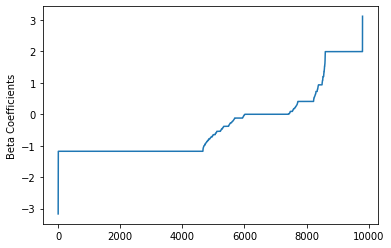

In [10]:
# LOGISTIC REGRESSION
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

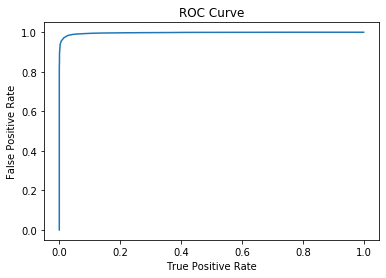

Training set areaUnderROC: 0.9973075657666336


In [11]:
# RECEIVER-OPERATING CHARACTERISTIC & AREA UNDER ROC
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


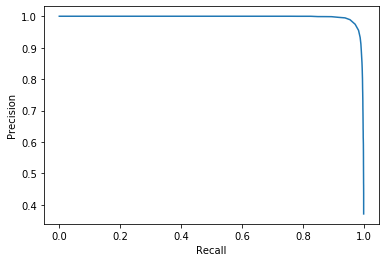

In [12]:
# PRECISION AND RECALL
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()




In [17]:
# PREDICTION ON TEST SET
predictions = lrModel.transform(test)
predictions.select('lead_time','is_canceled','label', 'rawPrediction', 'prediction', 'probability').show(10)

+------------+---------+-----------+-----+--------------------+----------+--------------------+
|       hotel|lead_time|is_canceled|label|       rawPrediction|prediction|         probability|
+------------+---------+-----------+-----+--------------------+----------+--------------------+
|Resort Hotel|        0|          0|  0.0|[1.30626719384830...|       0.0|[0.78688785196656...|
|Resort Hotel|        9|          0|  0.0|[1.30610688492271...|       0.0|[0.78686096766714...|
|Resort Hotel|        2|          0|  0.0|[1.30610688492271...|       0.0|[0.78686096766714...|
|Resort Hotel|       54|          0|  0.0|[1.30642750277389...|       0.0|[0.78691473379324...|
|Resort Hotel|        2|          0|  0.0|[1.30626719384830...|       0.0|[0.78688785196656...|
|Resort Hotel|       30|          0|  0.0|[1.30626719384830...|       0.0|[0.78688785196656...|
|Resort Hotel|        0|          0|  0.0|[1.30642750277389...|       0.0|[0.78691473379324...|
|Resort Hotel|        1|          0|  0.

In [14]:
# EVALUATE LOGISTIC REGRESSION MODEL
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))


Test Area Under ROC 0.9971815447514024


In [15]:
# FEATURE IMPORTANCE
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)


objectiveHistory:
0.6596320749716105
0.6571212706038133
0.650303538598424
0.6042000821284783
0.5262737692804434
0.38493318625189604
0.24693661558557706
0.16000997483687943
0.10507241866958192
0.07815141937926756
0.06496027548421197
+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|                 0.0|0.25400406045567336|
|                 0.0| 0.3736585994650511|
|                 0.0| 0.4097837646224743|
|                 0.0| 0.4394637620444072|
|                 0.0| 0.4690148561116303|
|                 0.0|0.49653572234217397|
|                 0.0| 0.5202217137701008|
|                 0.0| 0.5455512229705778|
|                 0.0| 0.5706873771389901|
|                 0.0| 0.5938577551480777|
|                 0.0|  0.616286938867584|
|                 0.0| 0.6400051561341884|
|                 0.0| 0.6642712126583095|
|                 0.0| 0.688601720859

LogisticRegression_2dcb66f06267

In [16]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(train)

print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")
mlrModel = mlr.fit(train)

print("Multinomial coefficients: " + str(mlrModel.coefficientMatrix))
print("Multinomial intercepts: " + str(mlrModel.interceptVector))


Coefficients: (9803,[9786,9787,9789],[-1.1027105791478315,0.857372302507216,0.0001603089255944399])
Intercept: -0.5267394086988646
Multinomial coefficients: 2 X 9803 CSRMatrix
(0,9786) 0.6133
(0,9787) -0.444
(0,9789) -0.0001
(1,9786) -0.6133
(1,9787) 0.444
(1,9789) 0.0001
Multinomial intercepts: [0.2633643200890572,-0.2633643200890572]
